<a href="https://colab.research.google.com/github/mattlamachado/King_County_DNC/blob/main/34012_Roof_Imoveis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# King County opção de investimento
5 imóveis que ela deveria investir e o porquê e quais 5 você não recomendaria o investimento de jeito nenhum.

In [2]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
# import geopandas as gpd

roof = pd.read_csv('kingcounty/kc_house_data.csv')

In [3]:
roof.info()
roof_c = roof.copy()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

## Limpeza do dado

In [30]:
display(roof_c.agg(['min', 'mean', 'max']))

C:\Users\cetem\AppData\Local\Temp\ipykernel_12704\2916524930.py:1: FutureWarning: ['date'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  display(roof_c.agg(['min', 'mean', 'max']))


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,lat,long,sqft_living15,sqft_lot15,price_sqft,zprice_all,zprice,sqft15_score,SCORE,SCORE_all
min,1.000102e+06,20140502T000000,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,...,47.155900,-122.519000,399.000000,651.000000,87.588235,-1.604317e+00,-3.406637e+00,0.000000,0.061574,0.138764
mean,4.580302e+09,NaN,5.400881e+05,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,...,47.560053,-122.213896,1986.552492,12768.455652,264.156594,3.698517e-16,1.841040e-17,0.004895,0.469607,0.858766
max,9.900000e+09,20150527T000000,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,...,47.777600,-121.315000,6210.000000,871200.000000,810.138889,4.960849e+00,1.019591e+01,1.000000,2.023155,2.822950


In [42]:
print(set(roof_c['bedrooms']), set(roof_c['bathrooms']), 
set(roof_c['floors']), set(roof_c['waterfront']), set(roof_c['view']),
set(roof_c['condition']), set(roof_c['grade']) 
, sep = '\n')

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 33}
{0.75, 1.0, 2.0, 2.25, 3.0, 4.5, 1.5, 2.5, 1.75, 2.75, 3.25, 4.0, 3.5, 4.75, 5.0, 0.0, 3.75, 8.0, 4.25, 5.25, 5.5, 5.75, 1.25, 6.0, 0.5, 6.75, 6.25, 7.5, 7.75, 6.5}
{1.0, 2.5, 2.0, 3.0, 1.5, 3.5}
{0, 1}
{0, 1, 2, 3, 4}
{1, 2, 3, 4, 5}
{1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13}


In [51]:
a = np.array([-1.7, -1.5, -0.2, 0.2, 1.5, 1.7, 2.0])
(np.floor(a,a))
a

array([-2., -2., -1.,  0.,  1.,  1.,  2.])

## Diferentes ZIPcodes de King County

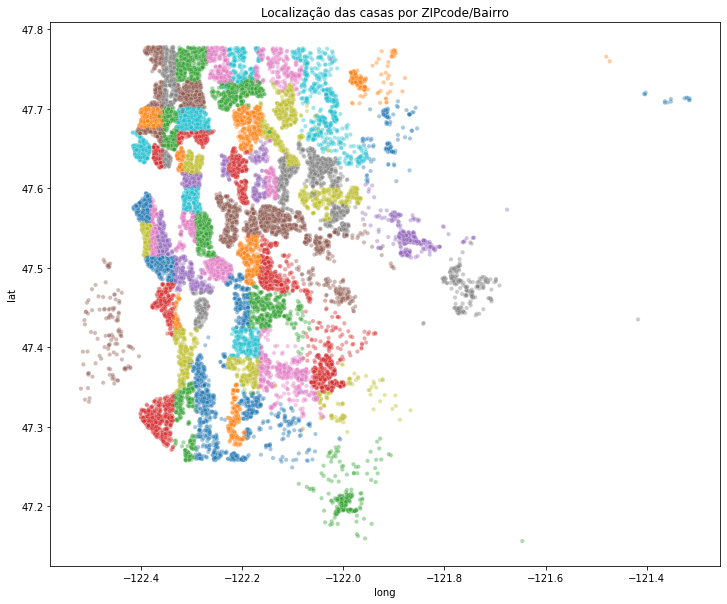

In [4]:
plt.figure(figsize=[12,10])
plt.title('Localização das casas por ZIPcode/Bairro')
sns.scatterplot(x = roof_c['long'], y = roof_c['lat'], size=0.001, alpha=0.4, legend=False, 
hue = roof_c['zipcode'], palette='tab10')

plt.show()

## Insights
- Calcule o lucro/ perda de investimento caso o imóvel seja vendido mais de uma vez naquele período.


## Definição de Preço por pé<sup>2</sup>

In [5]:
roof_c['price_sqft'] = roof_c['price']/roof_c['sqft_living']
print(roof_c['price_sqft'])

0        188.050847
1        209.338521
2        233.766234
3        308.163265
4        303.571429
            ...    
21608    235.294118
21609    173.160173
21610    394.216667
21611    250.000000
21612    318.627451
Name: price_sqft, Length: 21613, dtype: float64


## Cálculo do Z score do \$/pé<sup>2</sup>
z-score = (valor - média)/desvpad

Neste caso o ideal era calcular o z-score baseade na média do valor do imóvel dentro de um raio de procura, tipo 5 km.
Ou a média por "bairro", ou seja 'zipcode'.


Primeiramente, o z-score foi calculado considerando a média e desviopadrão para tds os imóveis, consequentemente, os imóveis das áreas mais ricas ficaram supervalorizados, mas quando faz-se o z-score comparando o valor com os imóveis de mesmo ZIPcode, a realidade muda bastante, oportunidades de investimentos em áreas nobres passam a surgir, pois em comparação as redondezas, esses imóveis estão com um preço atrativo.

### z-score antigo

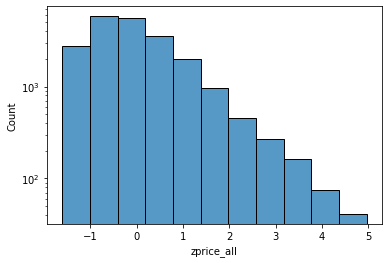

In [6]:
roof_c['zprice_all'] = pd.Series( (roof_c['price_sqft'] - (np.mean(roof_c['price_sqft']))) / np.std(roof_c['price_sqft']))

plt.figure()
sns.histplot(roof_c['zprice_all'], bins=11)
plt.yscale('log')
plt.show()




### z-score novo

In [7]:
for i,n in enumerate(roof_c['zipcode']):
    roof_c.loc[i, 'zprice'] = (roof_c.loc[i, 'price_sqft'] - np.mean(roof_c['price_sqft'][roof_c['zipcode'] == n])) / np.std(roof_c['price_sqft'][roof_c['zipcode'] == n], ddof=0)

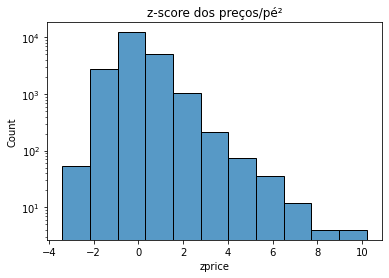

In [8]:
plt.figure()
plt.title('z-score dos preços/pé\u00b2')
sns.histplot(roof_c['zprice'], bins=11)
plt.yscale('log')
plt.show()

## Cálculo da diferença do tamanho do imóvel em relação a vizinhança
Quão discrepante for o imóvel, para mais ou para menos em relação a vizinhança, menor vai ser o score final, assumindo que nenhum comprador queira adquirir um imóvel fora dos padrões da vizinhança.

O Valor foi elevado ao quadrado para o efeito da discrepância não ser linear.

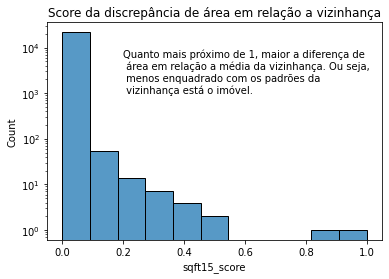

In [9]:
roof_c['sqft15_score'] = np.abs(roof_c['sqft_living'] - roof_c['sqft_living15'])**2
roof_c['sqft15_score'] /= max(roof_c['sqft15_score'])

plt.figure()
plt.title('Score da discrepância de área em relação a vizinhança')
sns.histplot(roof_c['sqft15_score'], bins=11)
plt.yscale('log')
anotacao = 'Quanto mais próximo de 1, maior a diferença de \n área em relação a média da vizinhança. Ou seja, \n menos enquadrado com os padrões da \n vizinhança está o imóvel.'
plt.annotate(anotacao, (0.2, 1000), )
plt.show()

## Contrução do Score do imóvel

Dividindo as variáves pelos seus ranges, trazendo todas para a mesma escala entre 0-1:

$Score = ( ('waterfront') + ('view'/4) + ('condition'/5) + ('grade'/13) + (('yr\_built' - 1900)/115) + ('yr\_renovated'/2015) - ('sqft15_score') ) / ('zprice' + abs(min('zprice')) + 1 )$

As variáveis do numerador ***aumentam o grau de atratividade*** de investimento em um imóvel, exceto ***'sqft15_score'*** o ***z-score*** representa quão distante da média o \$/m<sup>2</sup> está em relação ao King County em geral. ***Dividindo o score pelo z-score***, os imóveis com maiores valores de z-score, ou seja, com ***\$/m<sup>2</sup> muito acima da média, estão superprecificadas e tem seu score reduzido proporcionalmente***, reduzindo a tratividade de investimento.

In [10]:
pesos = dict({
    'waterfront':1.5,'view':1.2,
    'condition':1.2, 'grade':1,
    'yr_built':1, 'yr_renovated':0.5,
    'sqft15_score':1
})

In [11]:

roof_c['SCORE'] = ( (roof_c['waterfront'])*pesos['waterfront'] + (roof_c['view']/4)*pesos['view'] + ((roof_c['condition']-1)/4)*pesos['condition'] + ((roof_c['grade']-1)/12)*pesos['grade'] + ((roof_c['yr_built'] - 1900)/115)*pesos['yr_built'] - (roof_c['sqft15_score'])*pesos['sqft15_score'])

# for i in roof_c['yr_renovated'].index:
#     if roof_c['yr_renovated'][i]!=0:
#         roof_c['SCORE'][i] = roof_c['SCORE'][i] + ((roof_c['yr_renovated'][i]-1900)/115)*pesos['yr_renovated']

for i, n in enumerate(roof_c['yr_renovated']):
    if n != 0:
        roof_c.loc[i, 'SCORE'] += ((n - 1900)/115)*pesos['yr_renovated']

roof_c['SCORE'] /= (roof_c['zprice'] + abs(min(roof_c['zprice'])) + 1)

$roof_c['SCORE'] =$ 

$(( (roof_c['waterfront'])*pesos['waterfront'] + (roof_c['view']/4)*pesos['view'] + ((roof_c['condition']-1)/4)*pesos['condition'] + ((roof_c['grade']-1)/12)*pesos['grade'] + ((roof_c['yr_built'] - 1900)/115)*pesos['yr_built'] + (((roof_c['yr_renovated']/2015) - (1900/2015))*17.5217391297)*pesos['yr_renovated'] - (roof_c['sqft15_score'])*pesos['sqft15_score'])$

---

$(roof_c['zprice'] + abs(min(roof_c['zprice'])) + 1))$


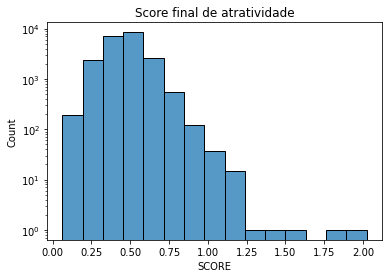

In [12]:
plt.figure()
plt.title('Score final de atratividade')
sns.histplot(roof_c['SCORE'], bins=15)
plt.yscale('log')
plt.show()

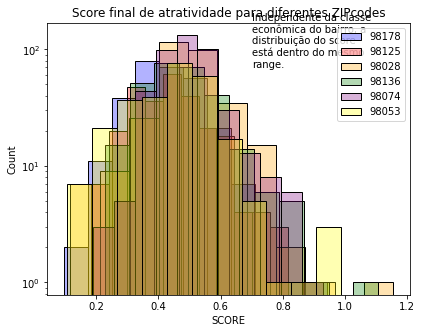

In [13]:
colors = ['blue', 'red', 'orange', 'green', 'purple', 'yellow']

plt.figure(figsize=(6.5,5))
plt.title('Score final de atratividade para diferentes ZIPcodes')

for i, x in enumerate(set(roof_c.loc[range(0,len(roof_c['zipcode']), 4000),'zipcode'])):
    sns.histplot(roof_c['SCORE'][roof_c['zipcode'] == x], bins=11, color=colors[i], alpha = 0.3)
plt.yscale('log')
plt.legend(roof_c['zipcode'])
msg = 'Independente da classe \neconômica do bairro, a \ndistribuição do score \nestá dentro do mesmo \nrange.'
plt.annotate(msg, (0.7,70))
plt.show()

## SCORE método antigo

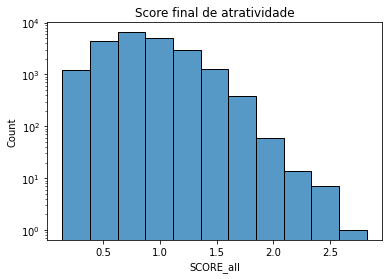

In [14]:
roof_c['SCORE_all'] = (( (roof_c['waterfront']) + (roof_c['view']/4) + (roof_c['condition']/5) + (roof_c['grade']/13) + ((roof_c['yr_built'] - 1900)/115) + ((roof_c['yr_renovated'])/2015)*0.5 - (roof_c['sqft15_score'])) / (roof_c['zprice_all'] + abs(min(roof_c['zprice_all'])) + 1))

plt.figure()
plt.title('Score final de atratividade')
sns.histplot(roof_c['SCORE_all'], bins=11)
plt.yscale('log')
plt.show()

In [15]:
columns = ['waterfront', 'view', 'condition', 'grade', 'yr_built', 'yr_renovated', 'sqft15_score', 'zprice', 'SCORE']
roof_c[columns].agg(['min', 'mean', 'max'])

,waterfront,view,condition,grade,yr_built,yr_renovated,sqft15_score,zprice,SCORE
min,0.000000,0.000000,1.00000,1.000000,1900.000000,0.000000,0.000000,-3.406637e+00,0.061574
mean,0.007542,0.234303,3.40943,7.656873,1971.005136,84.402258,0.004895,1.841040e-17,0.469607
max,1.000000,4.000000,5.00000,13.000000,2015.000000,2015.000000,1.000000,1.019591e+01,2.023155


## 5 imóveis mais atrativos para investimento

In [16]:
display(roof_c.loc[:,columns].sort_values('SCORE', axis=0, ascending=False, inplace=False).head())

,waterfront,view,condition,grade,yr_built,yr_renovated,sqft15_score,zprice,SCORE
326,0,0,3,9,1987,0,0.000033,-3.406637,2.023155
21372,0,2,3,10,2015,0,0.051392,-2.798331,1.802275
21050,0,4,3,12,2007,0,0.179331,-2.196254,1.568855
3844,0,0,3,7,2007,0,0.001356,-2.968844,1.411245
11436,0,0,3,7,2007,0,0.001531,-2.910999,1.356548


## 5 imóveis menos atrativos para investimento

In [17]:
display(roof_c.loc[:,columns].sort_values('SCORE', axis=0, ascending=True, inplace=False).head())

,waterfront,view,condition,grade,yr_built,yr_renovated,sqft15_score,zprice,SCORE
13629,0,0,1,5,1932,0,0.006305,5.423579,0.061574
19452,0,0,1,1,1963,0,0.023424,3.231770,0.068653
8606,0,0,3,5,1953,0,0.017210,10.080076,0.095052
8623,0,0,2,4,1953,0,0.008057,6.132391,0.095152
5832,0,0,2,3,1950,0,0.002014,4.770025,0.098013


## Localização dos 10 imóveis baseado na média de \$/pé<sup>2</sup> de todo o King County

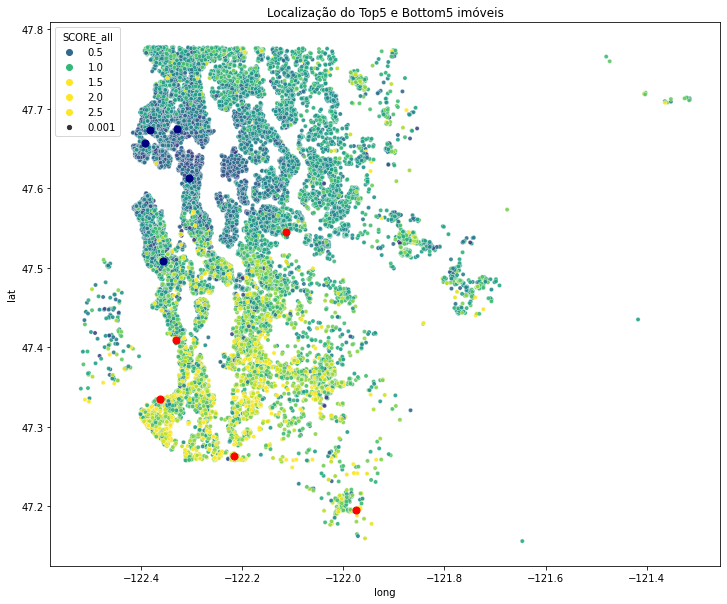

In [18]:
top5_all = roof_c.sort_values('SCORE_all', axis=0, ascending=False, inplace=False).head()
bottom5_all = roof_c.sort_values('SCORE_all', axis=0, ascending=True, inplace=False).head()

plt.figure(figsize=[12,10])
plt.title('Localização do Top5 e Bottom5 imóveis')
sns.scatterplot(x = roof_c['long'], y = roof_c['lat'], size=0.001, 
alpha=0.9, legend=True, hue=roof_c['SCORE_all'], palette='viridis', hue_norm=(0,1.5))

top5 = plt.scatter(top5_all['long'], top5_all['lat'], c = 'red', s = 50)
bottom5 = plt.scatter(bottom5_all['long'], bottom5_all['lat'], c = 'navy', s = 50)
# plt.legend([top5, bottom5], roof_c['SCORE'])

plt.show()

## Localização dos 10 imóveis baseado na média de \$/pé<sup>2</sup> por cada ZIPcode de King County

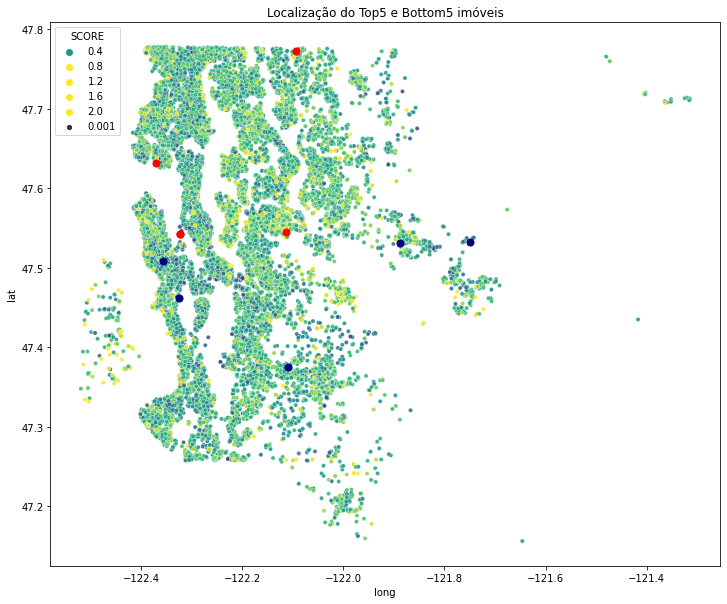

In [19]:
top5 = roof_c.sort_values('SCORE', axis=0, ascending=False, inplace=False).head()
bottom5 = roof_c.sort_values('SCORE', axis=0, ascending=True, inplace=False).head()

plt.figure(figsize=[12,10])
plt.title('Localização do Top5 e Bottom5 imóveis')
sns.scatterplot(x = roof_c['long'], y = roof_c['lat'], size=0.001, 
alpha=0.9, legend=True, hue=roof_c['SCORE'], palette='viridis', hue_norm=(0,0.75))

plt.scatter(top5['long'], top5['lat'], c = 'red', s = 50)
plt.scatter(bottom5['long'], bottom5['lat'], c = 'navy', s = 50)
# plt.legend(roof_c['SCORE'])


plt.show()

## extra

In [20]:
justNum = roof_c.select_dtypes(include='number')
justNum.drop(inplace = True, columns=['id', 'bedrooms', 'bathrooms', 'waterfront', 'SCORE', 'SCORE_all', 'zprice', 'zprice_all', 'lat', 'long', 'zipcode', 'sqft15_score', 'yr_renovated'])


<AxesSubplot:xlabel='grade', ylabel='price_sqft'>

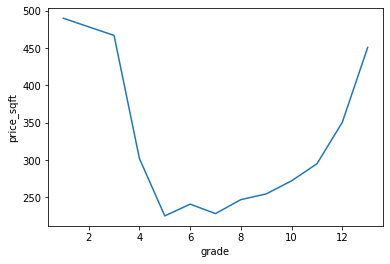

In [21]:
x = roof_c[['grade', 'price_sqft']].groupby('grade', as_index=False).agg('median')

plt.figure()
sns.lineplot(x=x['grade'], y=x['price_sqft'])

In [22]:
roof_c

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,lat,long,sqft_living15,sqft_lot15,price_sqft,zprice_all,zprice,sqft15_score,SCORE,SCORE_all
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,47.5112,-122.257,1340,5650,188.050847,-0.691504,-0.015239,0.000339,0.359321,0.845029
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,47.7210,-122.319,1690,7639,209.338521,-0.498082,-0.831467,0.010255,0.539520,0.980769
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,47.7379,-122.233,2720,8062,233.766234,-0.276130,0.163250,0.050354,0.274245,0.557576
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,47.5208,-122.393,1360,5000,308.163265,0.399849,-0.299124,0.004767,0.550321,0.698667
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,47.6168,-122.045,1800,7503,303.571429,0.358127,0.591208,0.000191,0.388100,0.665571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,263000018,20140521T000000,360000.0,3,2.50,1530,1131,3.0,0,0,...,47.6993,-122.346,1530,1509,235.294118,-0.262247,-1.372387,0.000000,0.702368,0.923632
21609,6600060120,20150223T000000,400000.0,4,2.50,2310,5813,2.0,0,0,...,47.5107,-122.362,1830,7200,173.160173,-0.826802,-0.565798,0.003051,0.565394,1.239730
21610,1523300141,20140623T000000,402101.0,2,0.75,1020,1350,2.0,0,0,...,47.5944,-122.299,1020,2007,394.216667,1.181739,0.944574,0.000000,0.382685,0.551045
21611,291310100,20150116T000000,400000.0,3,2.50,1600,2388,2.0,0,0,...,47.5345,-122.069,1410,1287,250.000000,-0.128628,-0.027971,0.000478,0.476676,0.856026


In [23]:
w = roof_c[['grade', 'price_sqft', 'yr_built']].groupby('yr_built', as_index=False).agg('mean')
w

,yr_built,grade,price_sqft
0,1900,6.873563,350.234591
1,1901,7.034483,330.583633
2,1902,7.444444,358.021642
3,1903,6.869565,333.104382
4,1904,6.911111,372.887473
...,...,...,...
111,2011,8.184615,237.888352
112,2012,8.182353,221.920610
113,2013,8.467662,250.188472
114,2014,8.559928,264.821520


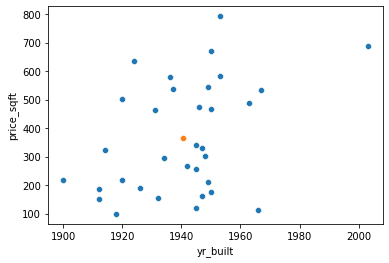

In [24]:
y = roof_c[roof_c['grade']<5]
plt.figure()
sns.scatterplot(x = y['yr_built'], y = y['price_sqft'])
sns.scatterplot(x = [y['yr_built'].mean()], y =[ y['price_sqft'].mean()]);


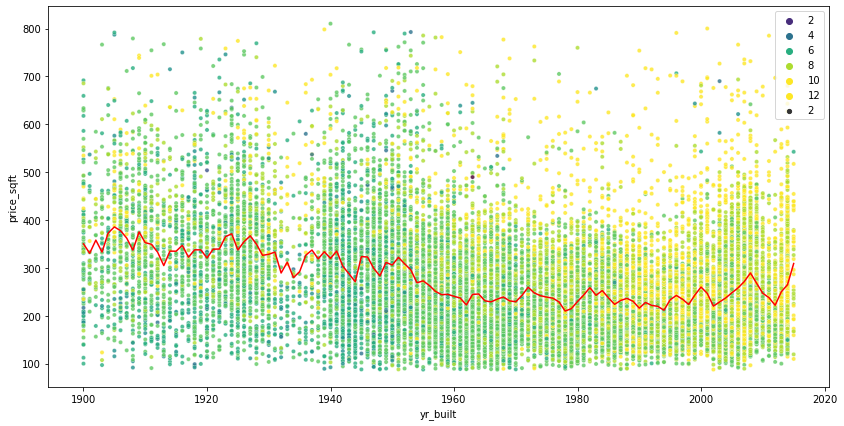

In [25]:
 
y = roof_c[roof_c['grade']>0]
plt.figure(figsize=(14,7))
sns.scatterplot(x = y['yr_built'], y = y['price_sqft'], alpha=0.8, size=2, hue=roof_c['grade'], palette='viridis', hue_norm=(1,9))
sns.lineplot(x = w['yr_built'], y = w['price_sqft'], color='r')
plt.show()

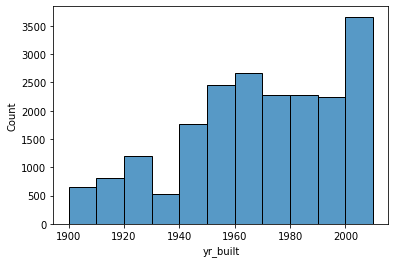

In [26]:
plt.figure()
sns.histplot(roof_c['yr_built'][roof_c['yr_built']<2011], bins=11);

In [27]:
print(roof_c['id'].shape)
print(len(set(roof_c['id'])))

(21613,)
21436


In [28]:
duplicates = [x for x in roof_c['id'] if roof_c['id'].groupby(axis=0, level=0).count(x) > 1]

print(duplicates)

TypeError: GroupBy.count() takes 1 positional argument but 2 were given

In [ ]:
mask = pd.Series(roof_c['zipcode'].values).groupby(axis=0, level=0).count()

roof_c[mask]

In [ ]:
mask = roof_c.groupby(roof_c.index).count(roof_c['id']) > 1
roof_c[mask]

TypeError: count() takes 1 positional argument but 2 were given